<a href="https://colab.research.google.com/github/johnJDN/FlowerCNN/blob/main/FlowerClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/johnJDN/FlowerCNN

import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')
# %cd '/content/drive/My Drive/'
# # alternatively, %cd '/content/drive/My Drive/my_folder/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

dataset_path = 'FlowerCNN/flower_images'

# the mean and std of ImageNet
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)

# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
    # do this for data augmentation (used when the dataset is limited) (creates more of the same image, but angled differently)
    transforms.RandomHorizontalFlip(p=0.3), 
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# Split the dataset into train & test containing 3460 and 863 images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (3460, 863))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

Cloning into 'FlowerCNN'...
remote: Enumerating objects: 4380, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 4380 (delta 3), reused 13 (delta 1), pack-reused 4365
Receiving objects: 100% (4380/4380), 226.86 MiB | 47.27 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Mounted at /content/gdrive
Using: cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))

PlotSamples(train_dataloader)

In [34]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (3,256,256))

NameError: ignored

In [5]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
        
        moutput = model(minput) # output by our model
        
        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader) # Returning Average Training Loss


def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()
            
            
            # To get the probabilities for different classes we need to apply a softmax operation on moutput 
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0], Test Loss: 2.3115, Accuracy: 0.20, Time: 4.67 sec
Epoch: [1]/(200/217), Train Loss: 1.6729, Accuracy: 0.22, Time: 18.06 sec
Epoch: [1], Test Loss: 1.6665, Accuracy: 0.21, Time: 4.64 sec


Epoch: [2]/(200/217), Train Loss: 1.5213, Accuracy: 0.24, Time: 17.93 sec
Epoch: [2], Test Loss: 1.6418, Accuracy: 0.22, Time: 4.60 sec


Epoch: [3]/(200/217), Train Loss: 1.3503, Accuracy: 0.26, Time: 17.86 sec
Epoch: [3], Test Loss: 1.3702, Accuracy: 0.38, Time: 4.60 sec


Epoch: [4]/(200/217), Train Loss: 1.4562, Accuracy: 0.38, Time: 17.87 sec
Epoch: [4], Test Loss: 1.3363, Accuracy: 0.40, Time: 4.70 sec


Epoch: [5]/(200/217), Train Loss: 1.3642, Accuracy: 0.43, Time: 18.02 sec
Epoch: [5], Test Loss: 1.2870, Accuracy: 0.40, Time: 4.59 sec


Epoch: [6]/(200/217), Train Loss: 1.2136, Accuracy: 0.46, Time: 17.95 sec
Epoch: [6], Test Loss: 1.2176, Accuracy: 0.45, Time: 4.72 sec


Epoch: [7]/(200/217), Train Loss: 1.4095, Accuracy: 0.50, Time: 18.24 sec
Epoch: [7], Test Loss: 1.1955, Accur

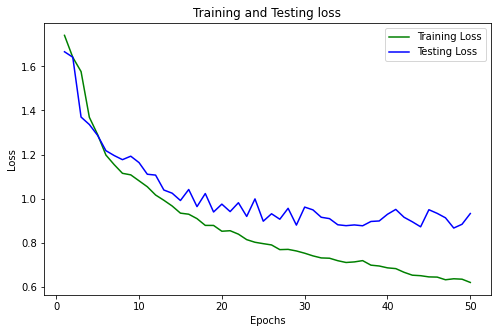

In [ ]:
lr = 0.0001
model = MyModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 51):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        model_save_name = f'classifier_{epoch}_epochs_4-26.pth'
        path = f"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
        torch.save(model.state_dict(), path)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

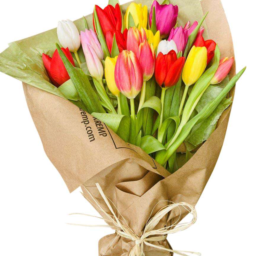

tulip : 96 % 




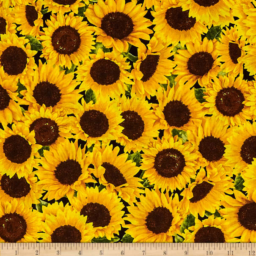

sunflower : 99 % 




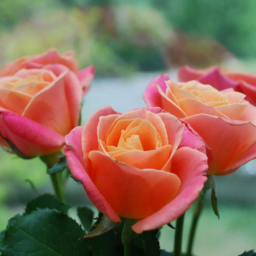

tulip : 86 % 




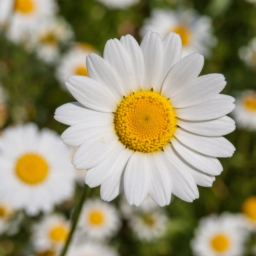

daisy : 99 % 




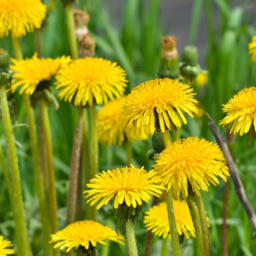

tulip : 87 % 




In [33]:
classes = ["tulip", "daisy", "dandelion", "rose", "sunflower"]

model_save_name = 'classifier_50_epochs_4-26.pth'
path = f"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}"
model.load_state_dict(torch.load(path))

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])

with torch.no_grad():

    for impath in os.listdir('FlowerCNN/test_images/'):
        try:
            image = Image.open(f'FlowerCNN/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = train_dataloader.dataset.dataset.classes[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(oclass, ':', moutput[idx], '%', '\n\n')

model.train()
pass

